In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import math


In [2]:
df = pd.read_csv("atp_matches.csv",sep="\t")
grand_slams = ['US Open', 'Australian Open', 'Wimbledon', 'Roland Garros']
df = df[df['tourney_name'].isin(grand_slams)].reset_index(drop=True) # filter only Grand slam matches


In [3]:
# calculate feature differences

df['age_diff'] = df['p1_age'] - df['p2_age']
df['serve_diff'] = df['p1_serve_rating']/100 - df['p2_serve_rating']/100
df['return_diff'] = df['p1_return_rating']/100 - df['p2_return_rating']/100
df['pressure_diff'] = df['p1_pressure_rating']/100 - df['p2_pressure_rating']/100


# percentage difference for ranking
df['rank_diff_pct'] = (df['p1_rank'] - df['p2_rank']) / ((df['p2_rank']+ df['p1_rank'])/2)
df['rank_points_diff_pct'] = (df['p1_rank_points'] - df['p2_rank_points']) / ((df['p2_rank_points']+df['p1_rank_points'])/2)


In [4]:
# Calculate win streak
df = df.sort_values(['tourney_date', 'match_num']).reset_index(drop=True)

df['p1_win_streak'] = 0
df['p2_win_streak'] = 0
player_win_streak = {}

for idx, row in df.iterrows():
    p1 = row['p1_id']
    p2 = row['p2_id']
    df.at[idx, 'p1_win_streak'] = player_win_streak.get(p1, 0)
    df.at[idx, 'p2_win_streak'] = player_win_streak.get(p2, 0)
    if row['p1_result'] == 1:
        # p1 wins, p2 loses
        player_win_streak[p1] = player_win_streak.get(p1, 0) + 1
        player_win_streak[p2] = 0
    else:
        # p1 loses, p2 wins
        player_win_streak[p1] = 0
        player_win_streak[p2] = player_win_streak.get(p2, 0) + 1

In [5]:
# calculate h2h

player_results = {} 
df['h2h'] = 0 
df = df.sort_values(['tourney_date', 'match_num']).reset_index(drop=True)

for idx, row in df.iterrows():
    p1, p2 = row['p1_id'], row['p2_id']

    p1_wins = player_results.get(p1, {}).get(p2, 0)
    p2_wins = player_results.get(p2, {}).get(p1, 0)
    df.at[idx, 'h2h'] = p1_wins - p2_wins

    player_results.setdefault(p1, {})[p2] = row['p1_result']
    player_results.setdefault(p2, {})[p1] = 1 - row['p1_result']


In [6]:
# calculate elo
df = df.sort_values(['tourney_date', 'match_num']).reset_index(drop=True)
BASE_ELO = 1600
K = 20
elo = {}

def expected_score(rating_a, rating_b):
    return 1 / (1 + 10 ** ((rating_b - rating_a) / 400))

p1_elo_list = []
p2_elo_list = []

for _, row in df.iterrows():
    p1 = row["p1_name"]
    p2 = row["p2_name"]
    result = row["p1_result"]

    p1_rating = elo.get(p1, BASE_ELO)
    p2_rating = elo.get(p2, BASE_ELO)

    p1_elo_list.append(p1_rating)
    p2_elo_list.append(p2_rating)

    exp_p1 = expected_score(p1_rating, p2_rating)
    exp_p2 = 1 - exp_p1

    score_p1 = result
    score_p2 = 1 - result

    elo[p1] = p1_rating + K * (score_p1 - exp_p1)
    elo[p2] = p2_rating + K * (score_p2 - exp_p2)

df["p1_elo"] = p1_elo_list
df["p2_elo"] = p2_elo_list



In [7]:
df['elo_diff'] = df['p1_elo'] - df['p2_elo']
df['elo_diff2'] = df['elo_diff'] ** 2
df['elo_diff3'] = df['elo_diff'] ** 3


In [8]:
features = [
  #  'age_diff',
    'rank_diff_pct',
    #'rank_points_diff_pct',
   #'elo_diff',
   # 'elo_diff3',
   # 'elo_diff2',
    'pressure_diff',
   'return_diff',
    'serve_diff'
]

In [9]:
# User-defined IV calucation function  

def iv_values(df, xvar_list, n_bins, target):
    for x in (xvar_list):
        df[f'{x}_bin'] = pd.cut(df[f'{x}'], bins=n_bins)
        df_iv = df.groupby(f'{x}_bin', observed=True) \
               .agg(nmatch = (target, 'count'), win_rate=(target,'mean'), nwin = (target,'sum') ) \
               .reset_index()
        df_iv['midpoint']  = df_iv[f'{x}_bin'].apply(lambda x: x.mid)
        df_iv['nloss']     = df_iv['nmatch'] - df_iv['nwin']
        # number of events(or non-events) cannot be zero
        df_iv['nloss']     = df_iv['nloss'].apply(lambda x: x if x > 0 else 0.5 )
        df_iv['nwin']      = df_iv['nwin'].apply(lambda x: x if x > 0 else 0.5 )
        # IV calculations
        df_iv['nwin_pct']  = df_iv['nwin'] / df_iv['nwin'].sum()
        df_iv['nloss_pct'] = df_iv['nloss'] / df_iv['nloss'].sum()
        df_iv['iv'] = (np.log(df_iv['nwin_pct']) - np.log(df_iv['nloss_pct']) ) * (df_iv['nwin_pct'] - df_iv['nloss_pct'])
        print(round(df_iv['iv'].sum(), 3), ' = ', f'{x}' ' (IV)')
        df = df.drop([f'{x}_bin'], axis = 1)


In [10]:
n_bins = 10
target = 'p1_result'
iv_values(df, features, n_bins, target)


1.076  =  rank_diff_pct (IV)
0.799  =  pressure_diff (IV)
0.246  =  return_diff (IV)
0.453  =  serve_diff (IV)


NameError: name 'ln' is not defined

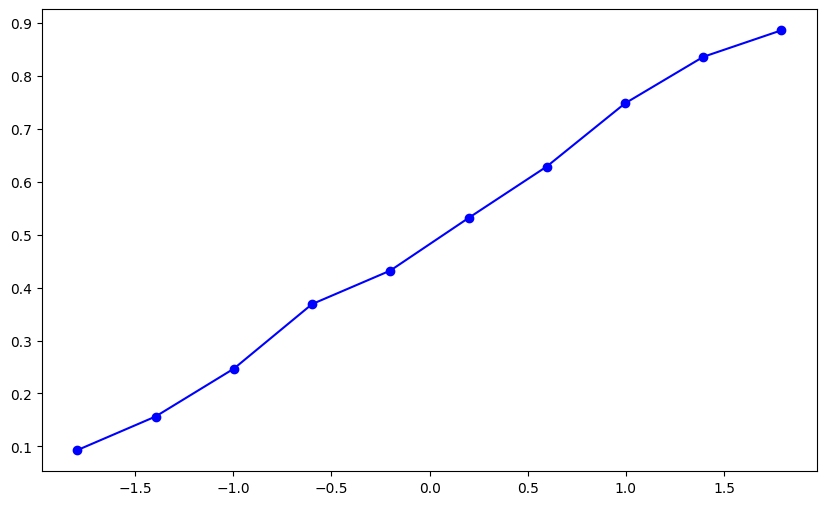

In [11]:
n_bins = 10  

#features_to_plot = ['pressure_diff', 'serve_diff', 'return_diff']
features_to_plot = ['rank_points_diff_pct']
colors = ['blue', 'green', 'red']

plt.figure(figsize=(10,6))

for feature, color in zip(features_to_plot, colors):
    df[f'{feature}_bin'] = pd.cut(df[feature], bins=n_bins)
    win_rate = df.groupby(f'{feature}_bin', observed=True)['p1_result'].mean().reset_index()
    bin_midpoints = win_rate[f'{feature}_bin'].apply(lambda x: x.mid)
    plt.plot(bin_midpoints, win_rate['p1_result'], marker='o', color=color, label=feature)


    ln(p/1-p)

plt.xlabel("Feature Difference")
plt.ylabel("P1 Win Rate")
plt.title("P1 Win Rate vs Pressure, Serve, and Return Differences")
plt.legend()
plt.grid(True)
plt.savefig("p1_difference_winrate.png", dpi=300)
plt.show()

In [ ]:
def xy_plot(var_list):
    n_bins = 10  
    features_to_plot = var_list
    colors = ['blue']

    plt.figure(figsize=(10,6))

    for feature, color in zip(features_to_plot, colors):
        df[f'{feature}_bin'] = pd.cut(df[feature], bins=n_bins)
        win_rate = df.groupby(f'{feature}_bin', observed=True)['p1_result'].mean().reset_index()
        bin_midpoints = win_rate[f'{feature}_bin'].apply(lambda x: x.mid)
        plt.plot(bin_midpoints, win_rate['p1_result'], marker='o', color=color, label=feature)

    x_label = f'{features_to_plot}'
    y_label = "P1 Win Rate"
    plot_title = 'P1 Win Rate by ' + f'{features_to_plot}'
    save_filename= f'{features_to_plot}'+'.png'

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(plot_title)
    plt.legend()
    plt.grid(True)
    plt.savefig(save_filename, dpi=300)
    plt.show()

In [ ]:
def log_regression(df, features, target, start_year=1977, end_year=2024):
    results = []
    for test_year in range(start_year, end_year + 1):
        train_df = df[df['tourney_year'] < test_year]
        test_df = df[df['tourney_year'] == test_year]
        if train_df.empty or test_df.empty:
            continue  

        X_train = train_df[features].fillna(0)
        y_train = train_df[target]

        X_test = test_df[features].fillna(0)
        y_test = test_df[target]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        model = LogisticRegression(max_iter=1000)
        model.fit(X_train_scaled, y_train)

        y_test_pred = model.predict(X_test_scaled)
        test_acc = accuracy_score(y_test, y_test_pred)

        results.append({
            'year': test_year,
            'test_acc': test_acc
        })

    log_results_df = pd.DataFrame(results)
    plt.figure(figsize=(12,6))
    plt.plot(
        log_results_df['year'],
        log_results_df['test_acc'],
        marker='s',
        label='Test Accuracy'
    )
    plt.xlabel("Year")
    plt.ylabel("Accuracy")
    plt.title("Logistic Regression Accuracy Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()

    return log_results_df

log_results_df = log_regression(df, features, 'p1_result', start_year=2005, end_year=2024)


In [ ]:
def random_forest(df, features, target, start_year=2005, end_year=2024, gs_only=True):
    results = []
    importances = []
    for test_year in range(start_year, end_year + 1):
        train_df = df[df['tourney_year'] < test_year]
        test_df = df[df['tourney_year'] == test_year]
        if train_df.empty or test_df.empty:
            continue  

        X_train = train_df[features].fillna(0)
        y_train = train_df[target]

        X_test = test_df[features].fillna(0)
        y_test = test_df[target]

        # Scale
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Fast Random Forest
        model = RandomForestClassifier(
            n_estimators=150,
            max_depth=20,
            min_samples_split=5,
            n_jobs=-1,
            random_state=42
        )

        model.fit(X_train_scaled, y_train)

        y_test_pred = model.predict(X_test_scaled)
        test_acc = accuracy_score(y_test, y_test_pred)

        for feat, val in zip(features, model.feature_importances_):
            importances.append({
                "year": test_year,
                "feature": feat,
                "importance": val
            })

        results.append({
            "year": test_year,
            "test_acc": test_acc,
            "num_matches_tested": len(test_df)
        })

    rf_results_df = pd.DataFrame(results)
    importances_df = pd.DataFrame(importances)

    plt.figure(figsize=(12,6))
    plt.plot(rf_results_df['year'], rf_results_df['test_acc'], marker='s', label='Test Accuracy')
    plt.xlabel("Year")
    plt.ylabel("Accuracy")
    plt.title("Random Forest Test Accuracy Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()

    return rf_results_df, importances_df

rf_results_df, importances_df = random_forest(df, features, 'p1_result', gs_only=True)


In [ ]:
plt.figure(figsize=(12,6))

plt.plot(rf_results_df['year'], rf_results_df['test_acc'],
         marker='o', label='Random Forest Test Accuracy')

plt.plot(log_results_df['year'], log_results_df['test_acc'],
         marker='s', label='Logistic Regression Test Accuracy')

plt.xlabel("Year")
plt.ylabel("Test Accuracy")
plt.title("Random Forest vs Logistic Regression Test Accuracy Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("rf_lg_results.png", dpi=300)
plt.show()


In [12]:
importances_df.groupby("feature")['importance'].mean().sort_values().plot.barh(figsize=(8,6))
plt.title("Average Feature Importance Across all Years")
plt.savefig("feature_importance.png", dpi=300)
plt.show()


NameError: name 'importances_df' is not defined

In [13]:
train_df = df[df['tourney_year'] < 2023]

X_train = train_df[features].fillna(0)
y_train = train_df['p1_result']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

import statsmodels.api as sm

X_train_const = sm.add_constant(X_train_scaled)
logit_model = sm.Logit(y_train, X_train_const)
result = logit_model.fit()

coeffs_df = pd.DataFrame({
    "feature": ["const"] + features,
    "coef": result.params,
    "p_value": result.pvalues
})

print(coeffs_df.sort_values("p_value", ascending=True))


Optimization terminated successfully.
         Current function value: 0.552359
         Iterations 6
             feature      coef        p_value
x1     rank_diff_pct -0.662052  1.024727e-141
x4        serve_diff  0.442127   1.094507e-40
x3       return_diff  0.341635   3.157435e-29
x2     pressure_diff  0.248225   4.226557e-13
const          const -0.032493   8.826022e-02


In [14]:
rf_avg = rf_results_df['test_acc'].mean()
lr_avg = log_results_df['test_acc'].mean()

print("Average Random Forest Accuracy:", round(rf_avg, 4))
print("Average Logistic Regression Accuracy:", round(lr_avg, 4))

NameError: name 'rf_results_df' is not defined

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

def train_final_logistic_model(df, features, target, end_year=2024):
    train_df = df[df['tourney_year'] <= end_year]

    X_train = train_df[features].fillna(0)
    y_train = train_df[target]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_scaled, y_train)

    return model, scaler


def predict_match_winner(match_df, features, model, scaler):
    """
    match_df: DataFrame with ONE ROW containing feature differences
    """

    X = match_df[features].fillna(0)
    X_scaled = scaler.transform(X)

    win_prob = model.predict_proba(X_scaled)[0][1]
    prediction = model.predict(X_scaled)[0]

    return win_prob, prediction


In [16]:
# Train final model
final_model, final_scaler = train_final_logistic_model(
    df,
    features,
    target='p1_result',
    end_year=2024
)

# Example match (replace values with real feature differences)
example_match = pd.DataFrame([{
    'rank_diff_pct': -0.12,
    'serve_difference': 0.35,
    'return_difference': 0.18,
    'pressure_difference': 0.22
}])

win_prob, prediction = predict_match_winner(
    example_match,
    features,
    final_model,
    final_scaler
)

winner = "Player A" if prediction == 1 else "Player B"

print(f"Predicted Winner: {winner}")
print(f"Win Probability (Player A): {win_prob:.2f}")


KeyError: "['pressure_diff', 'return_diff', 'serve_diff'] not in index"